# DELTA ANALYISIS - Gridded Data EMDA
## Ensemble of Meterological Dataset for North America 
### using probabilistc methods to estimate the uncertainty in spatial fields
https://essd.copernicus.org/articles/13/3337/2021/

*Each scenario represents a predicted socio-economic status and the radiative energy that the globe will reach by the end of the century (4 socio-economic scenarios paired with radiative force we are producing (KJ/m2)).  **SSP1-2.6** = assumes reduced emissions, **SSP2-4.5** = assumes the same trend of emissions as historical, **SSP3-7.0** = medium to high emissions scenario, **SSP5-8.5**=optimal for economic development but with high emissions.*

# Install Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import linregress
from itertools import combinations
import math
from matplotlib.dates import MonthLocator, DateFormatter
import requests
from io import StringIO
import os

# Hard Coded Variables

## Observed

In [2]:
observed_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Observed'
observed_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Observed/flow'

## S1

In [3]:
s1_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S1'
s1_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S1/flow'

## S2

In [4]:
s2_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S2'
s2_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S2/flow'

## S3

In [5]:
s3_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S3'
s3_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S3/flow'

## S4

In [6]:
s4_folder_t_p = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S4'
s4_folder_f = 'C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/S4/flow'

# Utility Functions

In [7]:
def read_csv_files_in_folder(folder_path):
    dataframes = []
    
    files = sorted(os.listdir(folder_path))  # Sort files alphabetically
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            dataframes.append(df)
    
    return dataframes


In [8]:
def merge_dataframes(df_t_p_list, df_f_list):
    """
    Merge two lists of DataFrames based on the 'Date' column.

    Parameters:
    - df_t_p_list: List of DataFrames with 'Date', 'tmean', and 'precip' columns, sorted by 'Date'
    - df_f_list: List of DataFrames with 'Date' and 'qmean' columns, sorted by 'Date'

    Returns:
    - Merged list of DataFrames on 'Date' column
    """
    merged_dfs = []

    # Ensure the length of both lists is the same
    assert len(df_t_p_list) == len(df_f_list), "The lengths of input lists must be the same."

    for df_t_p, df_f in zip(df_t_p_list, df_f_list):
        # Convert 'Date' column to datetime if not already
        if not pd.api.types.is_datetime64_any_dtype(df_t_p['Date']):
            df_t_p['Date'] = pd.to_datetime(df_t_p['Date'])

        if not pd.api.types.is_datetime64_any_dtype(df_f['Date']):
            df_f['Date'] = pd.to_datetime(df_f['Date'])

        merged_df = pd.merge(df_t_p, df_f, on='Date', how='outer')
        merged_dfs.append(merged_df)

    return merged_dfs

In [125]:
def plot_mean_monthly_trends(df_list, column_name, title_prefix=""):
    """
    Create an interactive plot for mean monthly data over time with a slider for zooming.

    Parameters:
    - df_list: List of DataFrames with 'Date' and specified column
    - column_name: Name of the column for plotting ('tmean' or 'precip')
    - title_suffix: String to be added to the title of the plot (default is an empty string)

    Returns:
    - None (displays the plot)
    """
    plt.figure(figsize=(15, 8))

    for i,df in enumerate(df_list):
        # Convert 'Date' column to datetime
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract month and year information
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        # Group by month and year, calculate mean data for each group
        mean_monthly_data = df.groupby(['Year', 'Month'])[column_name].mean().reset_index()

        # Filter for the first month of each year
        first_month_of_each_year = mean_monthly_data[mean_monthly_data['Month'] == 1]

        # Plot the mean monthly temperature or precip over time
        plt.plot(
            mean_monthly_data['Year'].astype(str) + '-' + mean_monthly_data['Month'].astype(str),
            mean_monthly_data[column_name],
            label=f"{title_prefix} - {i+1}"  # ??
        )

    unit = '(°C)' if column_name == 'tmean' else '(mm)'
    plt.xlabel('Year-Month')
    plt.ylabel(f'Mean Monthly {column_name.capitalize()} {unit}')
    plt.title(f'{title_prefix} Mean Monthly {column_name.capitalize()} Over Time')
    plt.legend()
    plt.xticks(first_month_of_each_year['Year'].astype(str) + '-' + first_month_of_each_year['Month'].astype(str), rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [10]:
# def plot_monthly_average(df_list, column_name, title_prefix=""):
#     """
#     Create a plot for the monthly average of a specified column across all DataFrames.

#     Parameters:
#     - df_list: List of DataFrames with 'Date' and specified column
#     - column_name: Name of the column for plotting
#     - title_prefix: String to be added to the title of the plot (default is an empty string)

#     Returns:
#     - None (displays the plot)
#     """
#     # Combine all dataframes into a single dataframe
#     combined_df = pd.concat(df_list, ignore_index=True)

#     # Convert 'Date' column to datetime
#     combined_df['Date'] = pd.to_datetime(combined_df['Date'])

#     # Extract month and year information
#     combined_df['Month'] = combined_df['Date'].dt.month

#     # Group by month and calculate the average of the specified column
#     monthly_avg_data = combined_df.groupby('Month')[column_name].mean()

#     # Plot the monthly average over all dataframes
#     plt.figure(figsize=(10, 6))
#     plt.plot(monthly_avg_data.index, monthly_avg_data.values, marker='o', linestyle='-', color='b')
    
#     unit = ''  # You can add a unit if needed
#     plt.xlabel('Month')
#     plt.ylabel(f'Monthly Average {column_name.capitalize()} {unit}')
#     plt.title(f'{title_prefix} Monthly Average {column_name.capitalize()} Over All Dataframes')
#     plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.tight_layout()
#     plt.show()



In [120]:
def plot_monthly_average_with_range(df_list, column_name, title_prefix=""):
    """
    Create a plot for the monthly average with range of a specified column across all DataFrames.

    Parameters:
    - df_list: List of DataFrames with 'Date' and specified column
    - column_name: Name of the column for plotting
    - title_prefix: String to be added to the title of the plot (default is an empty string)

    Returns:
    - None (displays the plot)
    """
    # Combine all dataframes into a single dataframe
    combined_df = pd.concat(df_list, ignore_index=True)

    # Convert 'Date' column to datetime
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])

    # Extract month and year information
    combined_df['Month'] = combined_df['Date'].dt.month

    # Group by month and calculate the average, minimum, and maximum of the specified column
    monthly_agg_data = combined_df.groupby('Month')[column_name].agg(['mean', 'min', 'max'])

    # Plot the monthly average, minimum, and maximum over all dataframes
    plt.figure(figsize=(15, 8))
    plt.plot(monthly_agg_data.index, monthly_agg_data['mean'], marker='o', linestyle='-', color='b', label='Average')
    plt.fill_between(
        monthly_agg_data.index,
        monthly_agg_data['min'],
        monthly_agg_data['max'],
        color='b',
        alpha=0.2,
        label='Range'
    )

    unit = '(°C)' if column_name == 'tmean' else '(mm)' if column_name == 'precip' else '(cms)'
    plt.xlabel('Month')
    plt.ylabel(f'{column_name.capitalize()} {unit}')
    plt.title(f'{title_prefix} Monthly Average with Range ({column_name.capitalize()}) Over All Realizations')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    #plt.yticks(range(int(min(monthly_agg_data['min'])), int(max(monthly_agg_data['max'])) + 1, 5))
    # Set the number of y-axis ticks
    plt.locator_params(axis='y', nbins=20)  # You can adjust the number of ticks as needed

    plt.grid(True, linestyle='--', alpha=0.7, which='both', axis='y')  # 'both' to show both major and minor grid lines

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [123]:
def plot_monthly_boxplot(df_list, column_name, title_prefix=""):
    """
    Create a box plot for the specified column across all DataFrames.

    Parameters:
    - df_list: List of DataFrames with 'Date' and specified column
    - column_name: Name of the column for plotting
    - title_prefix: String to be added to the title of the plot (default is an empty string)

    Returns:
    - None (displays the plot)
    """
    # Combine all dataframes into a single dataframe
    combined_df = pd.concat(df_list, ignore_index=True)

    # Convert 'Date' column to datetime
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])

    # Extract month and year information
    combined_df['Month'] = combined_df['Date'].dt.month

    # Prepare data for the box plot
    data = [group[column_name].dropna().values.tolist() for name, group in combined_df.groupby('Month')]

    # Create a box plot
    plt.figure(figsize=(15, 8))
    box = plt.boxplot(data, patch_artist=True)

    for box_patch in box['boxes']:
        box_patch.set_facecolor('skyblue')

    unit = '(°C)' if column_name == 'tmean' else '(mm)' if column_name == 'precip' else '(cms)'
    plt.xlabel('Month')
    plt.ylabel(f'{column_name.capitalize()} {unit}')
    plt.title(f'{title_prefix} Monthly Box Plot ({column_name.capitalize()})')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [116]:
def plot_monthly_grouped_boxplots(list_of_df_lists, column_name, title_prefix=""):
    """
    Create grouped box plots for the specified column across different sets of DataFrames.

    Parameters:
    - list_of_df_lists: List of lists of DataFrames with 'Date' and specified column
    - column_name: Name of the column for plotting
    - title_prefix: String to be added to the title of the plot (default is an empty string)

    Returns:
    - None (displays the plot)
    """
    # Create a subplot with 5 boxes per month
    fig, ax = plt.subplots(figsize=(15, 8))

    # Create color map for each list
    # cmap = plt.cm.get_cmap('Accent')
    cmap= plt.colormaps['Accent']
    colors = [cmap(i) for i in np.linspace(0, 1, len(list_of_df_lists))]

    # Iterate over each list of dataframes
    for idx, (df_list, color) in enumerate(zip(list_of_df_lists, colors)):
        # Combine dataframes in the same list into a single dataframe
        combined_df = pd.concat(df_list, ignore_index=True)

        # Convert 'Date' column to datetime
        combined_df['Date'] = pd.to_datetime(combined_df['Date'])

        # Extract month and year information
        combined_df['Month'] = combined_df['Date'].dt.month

        # Prepare data for the box plot
        data = [group[column_name].dropna().values.tolist() for name, group in combined_df.groupby('Month')]

        # Plot the grouped box plot with color
        positions = [i + idx * 0.2 for i in range(1, 13)]  # Adjust the position for each box
        boxes = ax.boxplot(data, positions=positions, widths=0.15, showfliers=False, patch_artist=True,
                           boxprops=dict(facecolor=color, color='black'))

    # Create legend
    legend_labels = ['Observed', 'S1', 'S2', 'S3', 'S4']
    legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black') for i in range(len(list_of_df_lists))]
    ax.legend(legend_handles, legend_labels, loc='upper left')

    unit = '(°C)' if column_name == 'tmean' else '(mm)' if column_name == 'precip' else '(cms)'
    ax.set_xlabel('Month')
    ax.set_ylabel(f'{column_name.capitalize()} {unit}')
    ax.set_title(f'{title_prefix} Grouped Monthly Box Plots ({column_name.capitalize()}) Over All Realizations')
    ax.set_xticks([i + 0.65 for i in range(1, 13)])  # Adjust position of month labels
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Data Engineering

## Observed

In [12]:
observed_t_p = read_csv_files_in_folder(observed_folder_t_p)
observed_f = read_csv_files_in_folder(observed_folder_f)

In [13]:
observed_dfs = merge_dataframes(observed_t_p, observed_f)

In [14]:
observed_dfs[0].head(2)

,Date,tmean,precip,qmean
0,1979-01-01,-24.9175,2.77110,0.000
1,1979-01-02,-21.8485,0.70797,0.003


## S1

In [15]:
s1_t_p = read_csv_files_in_folder(s1_folder_t_p)
# s1_f = read_csv_files_in_folder(s1_folder_f)

In [16]:
s1_t_p[33].head()

,Date,precip,tmean
0,2015-01-01,4.936669,-1.586552
1,2015-01-02,3.241493,-4.703470
2,2015-01-03,0.000000,-9.730744
3,2015-01-04,0.000000,-8.476225
4,2015-01-05,1.042195,-8.277044


In [17]:
# s1_dfs = merge_dataframes(s1_t_p, s1_f)

## S2

In [18]:
s2_t_p = read_csv_files_in_folder(s2_folder_t_p)
# s2_f = read_csv_files_in_folder(s2_folder_f)

In [19]:
# s2_dfs = merge_dataframes(s2_t_p, s2_f)

## S3

In [20]:
s3_t_p = read_csv_files_in_folder(s3_folder_t_p)
# s3_f = read_csv_files_in_folder(s3_folder_f)

In [21]:
# s3_dfs = merge_dataframes(s3_t_p, s3_f)

## S4

In [22]:
s4_t_p = read_csv_files_in_folder(s4_folder_t_p)
# s4_f = read_csv_files_in_folder(s4_folder_f)

In [23]:
# s4_dfs = merge_dataframes(s4_t_p, s4_f)

In [24]:
s4_t_p[39].head()

,Date,precip,tmean
0,2015-01-01,6.514761,1.966477
1,2015-01-02,8.052436,2.692204
2,2015-01-03,1.416353,0.828085
3,2015-01-04,23.150974,2.364892
4,2015-01-05,5.724569,-1.390870


# Analysis

## Observed

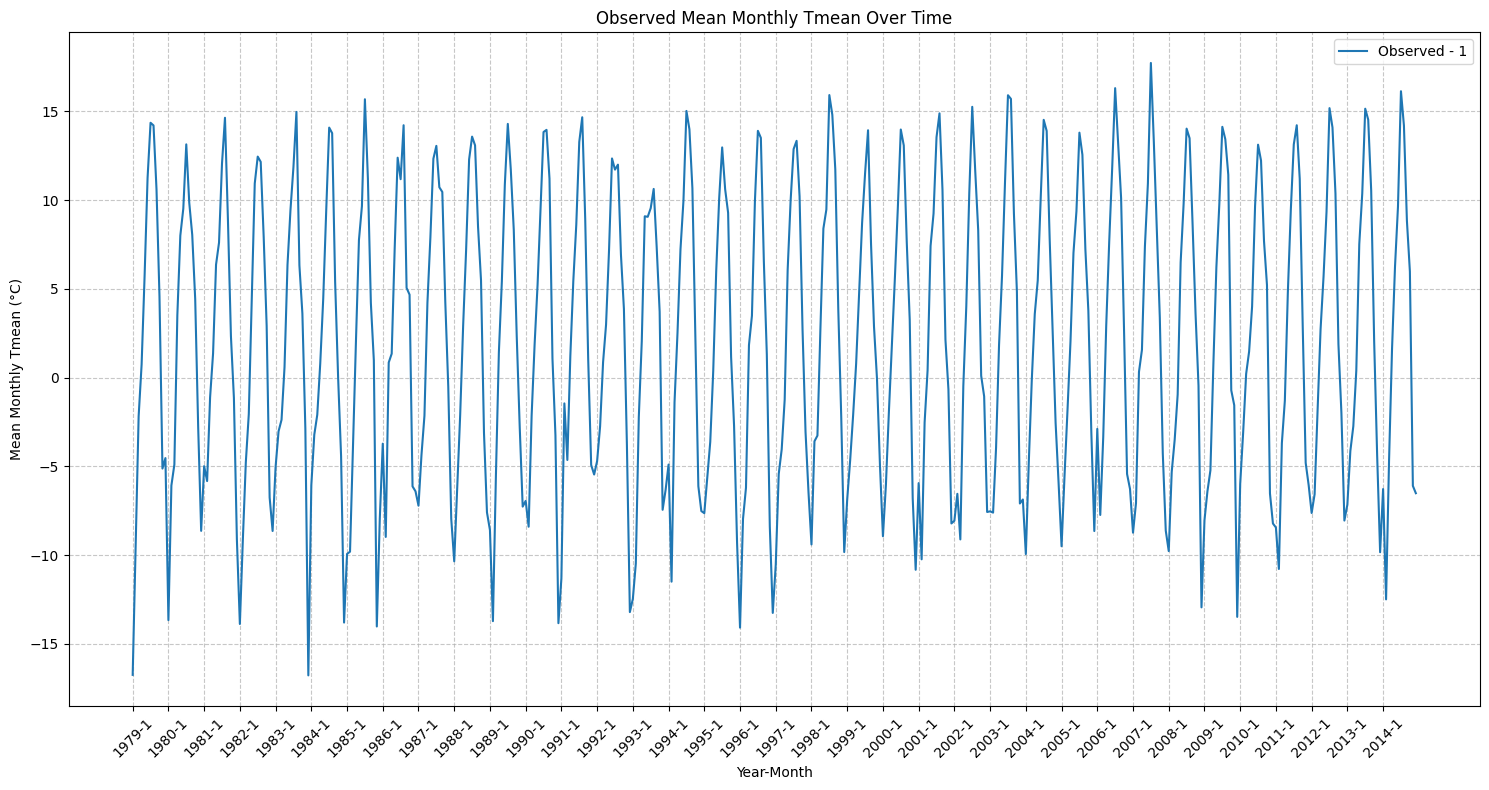

In [126]:
plot_mean_monthly_trends(observed_dfs, 'tmean', title_prefix='Observed')

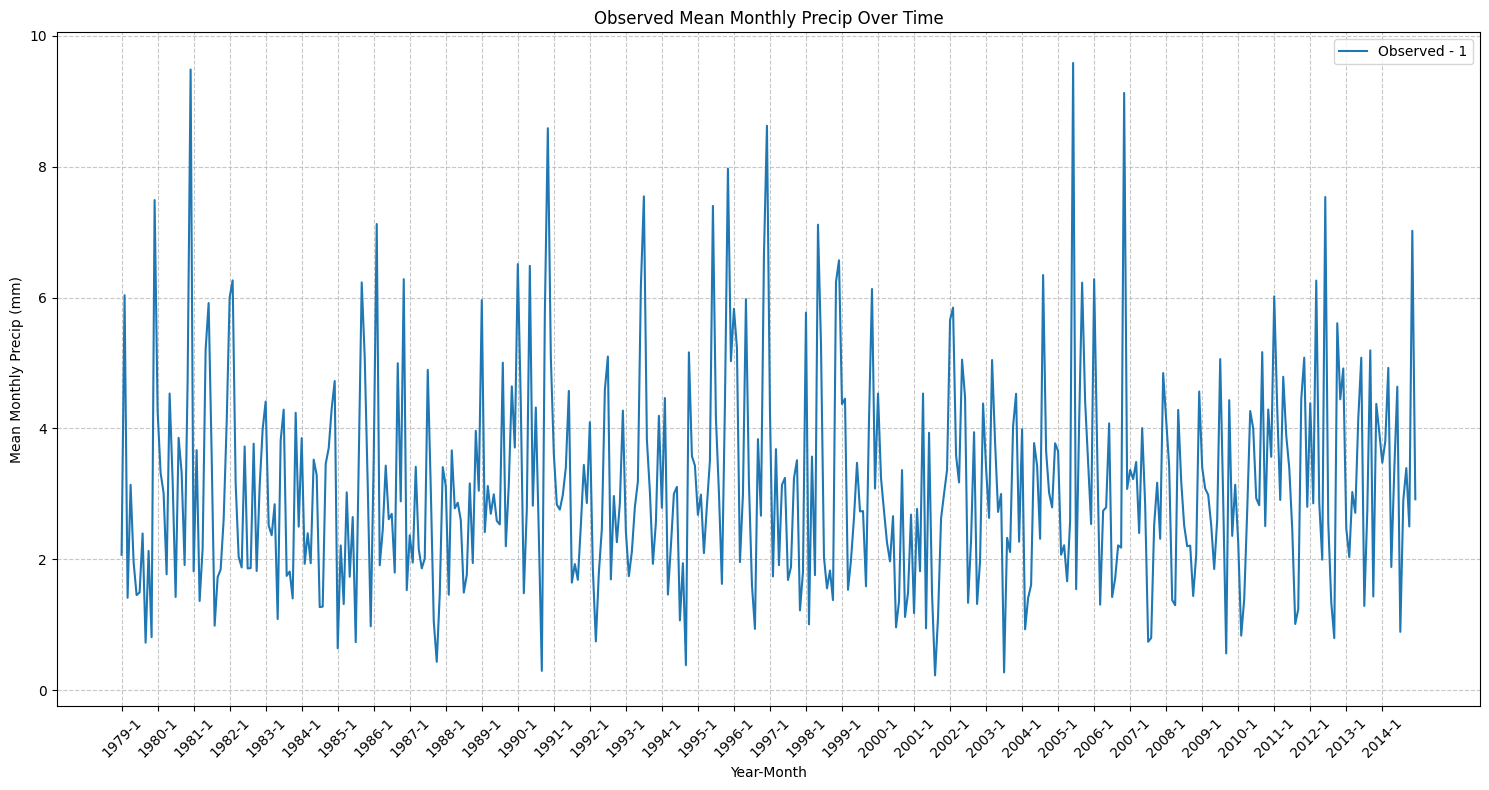

In [127]:
plot_mean_monthly_trends(observed_dfs, 'precip', title_prefix='Observed')

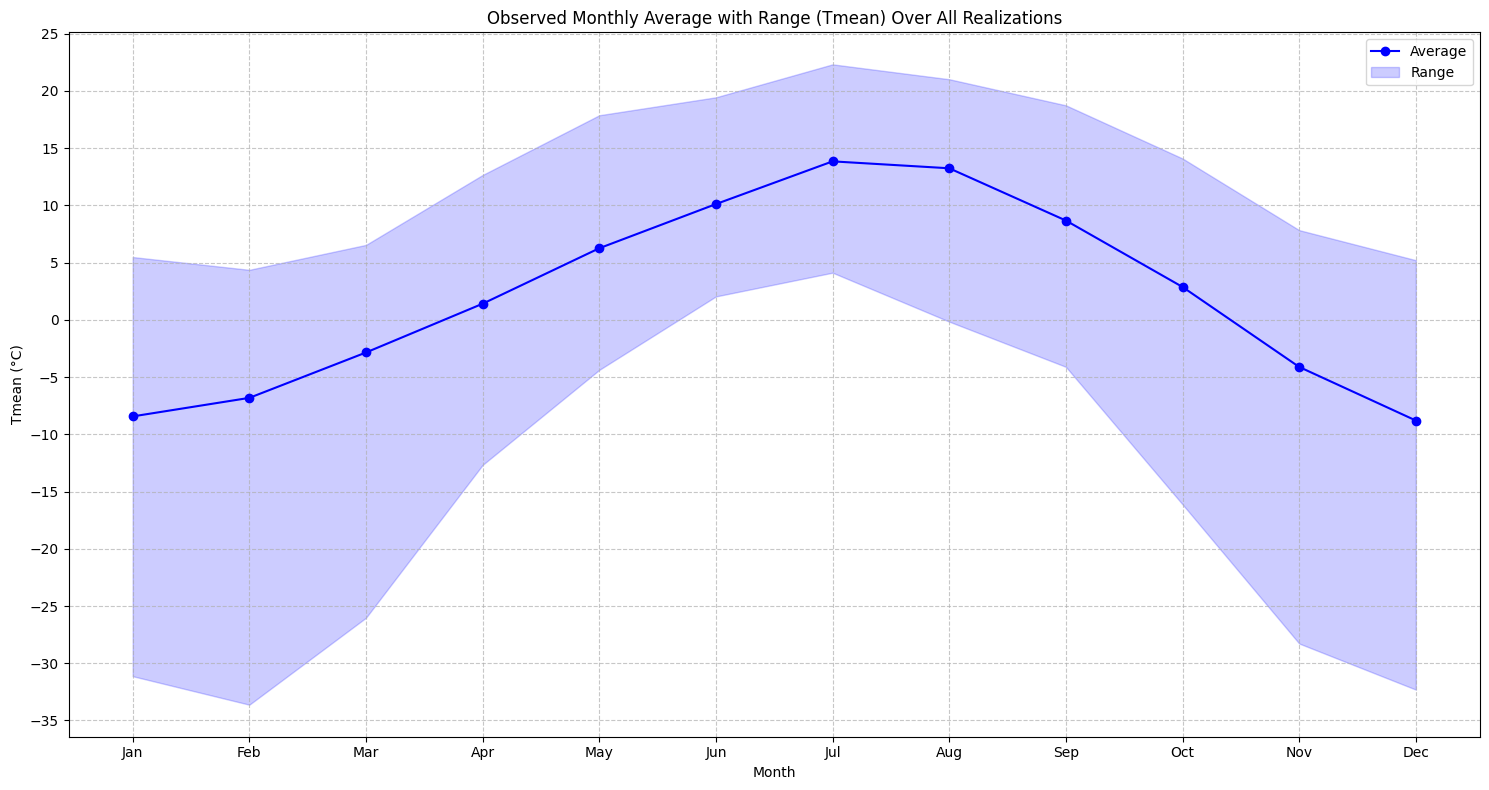

In [128]:
plot_monthly_average_with_range(observed_dfs, 'tmean', title_prefix="Observed")

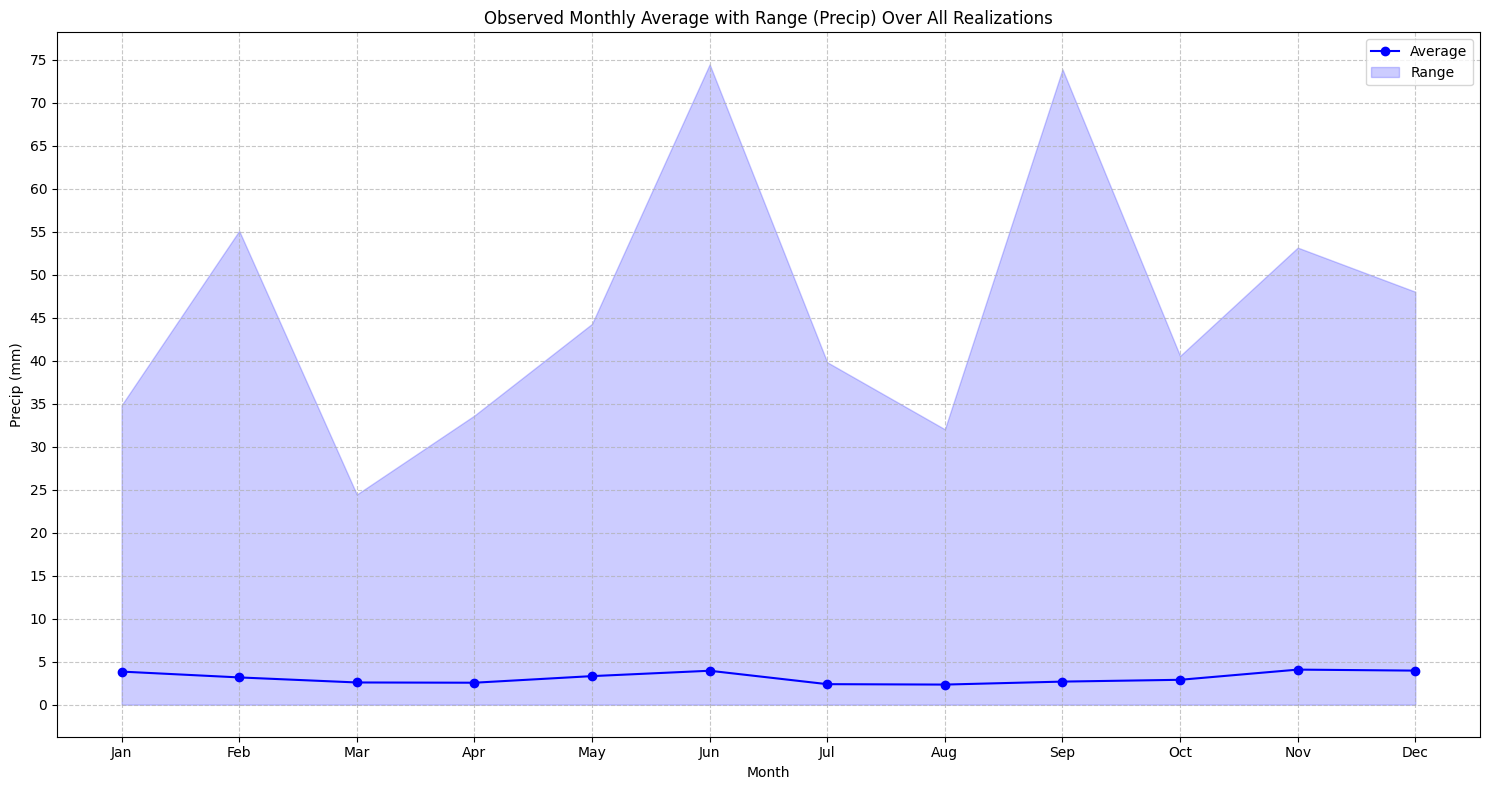

In [129]:
plot_monthly_average_with_range(observed_dfs, 'precip', title_prefix="Observed")

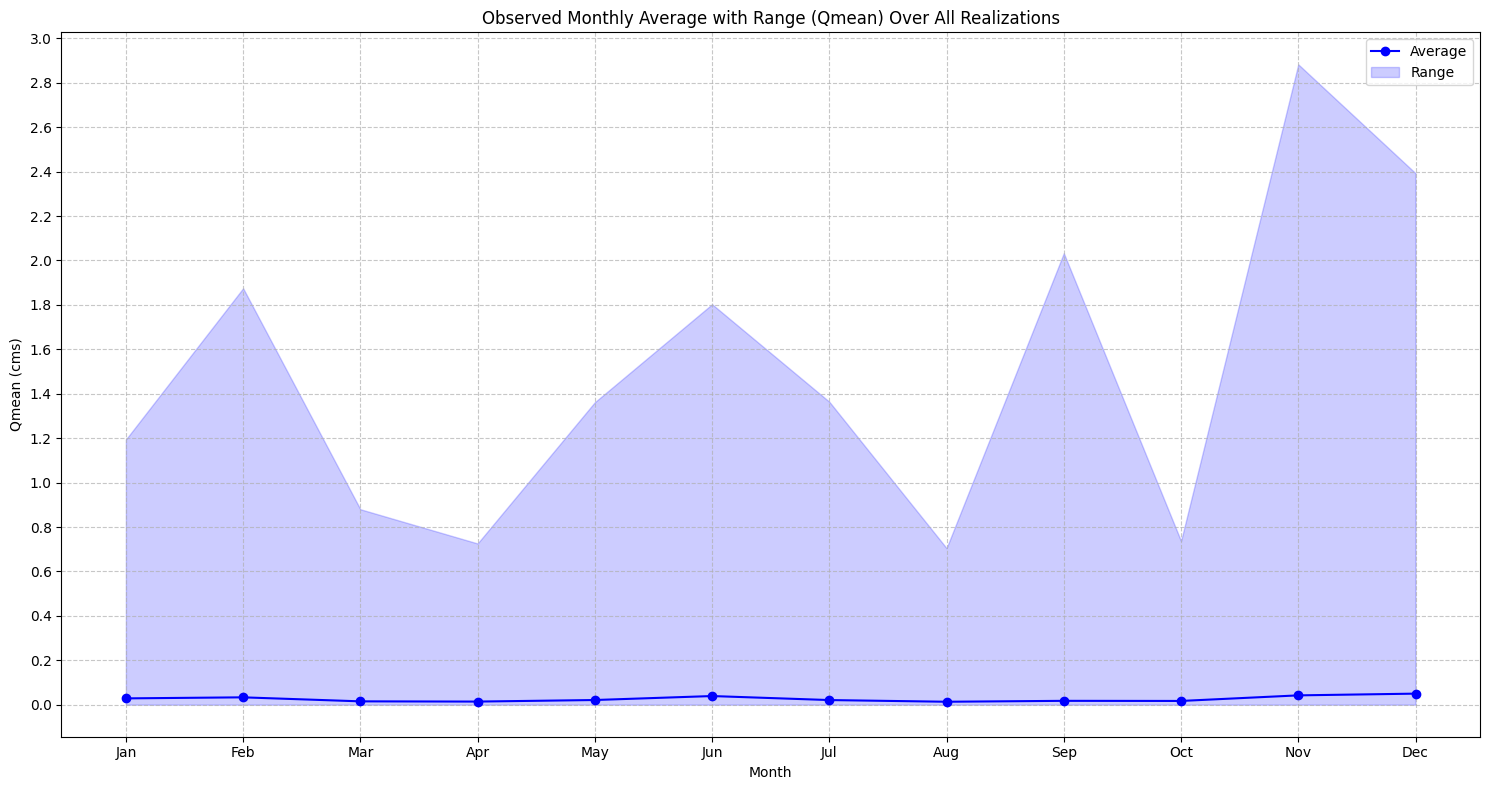

In [130]:
plot_monthly_average_with_range(observed_dfs, 'qmean', title_prefix="Observed")

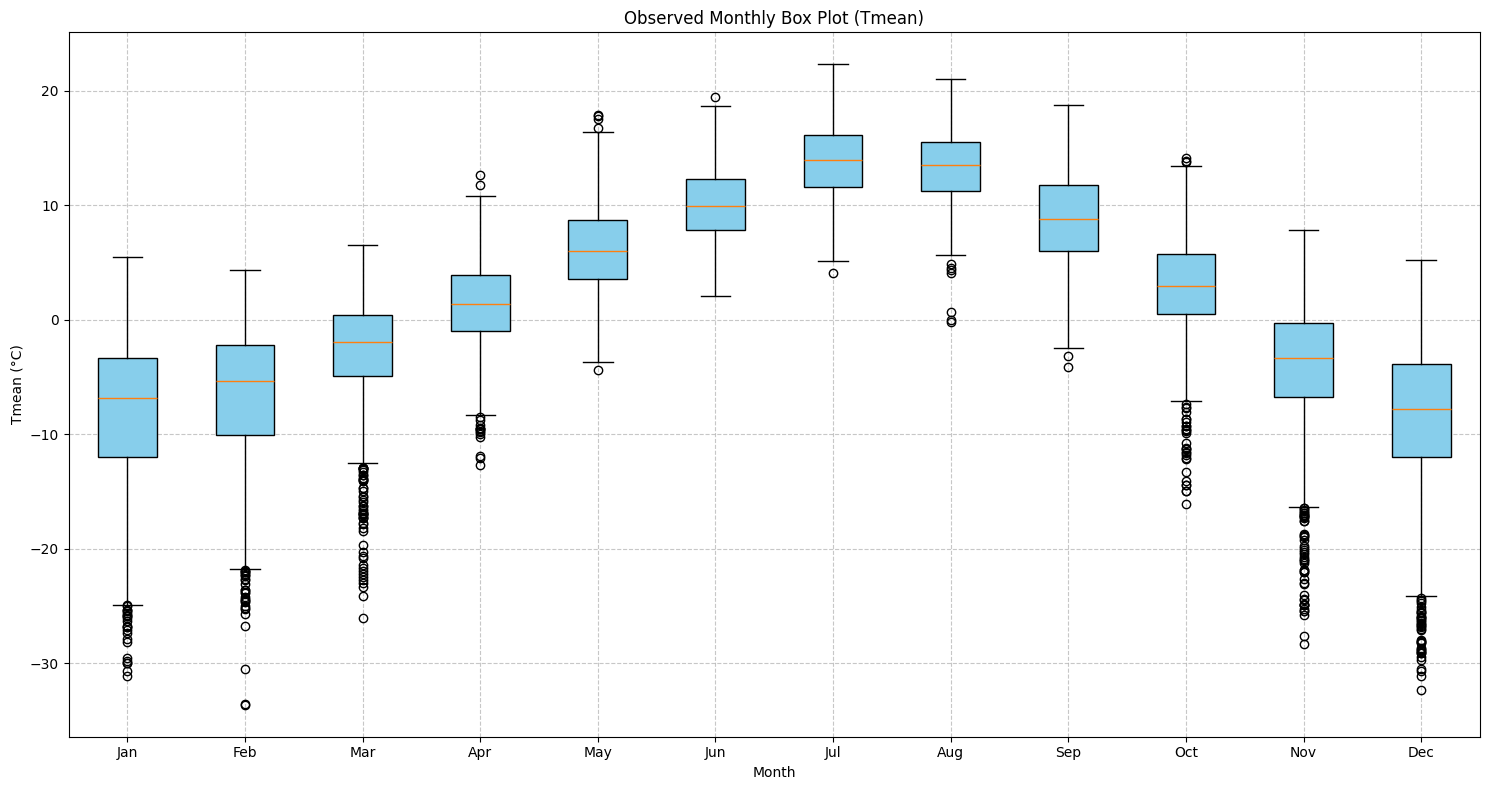

In [131]:
plot_monthly_boxplot(observed_dfs, 'tmean', title_prefix='Observed')


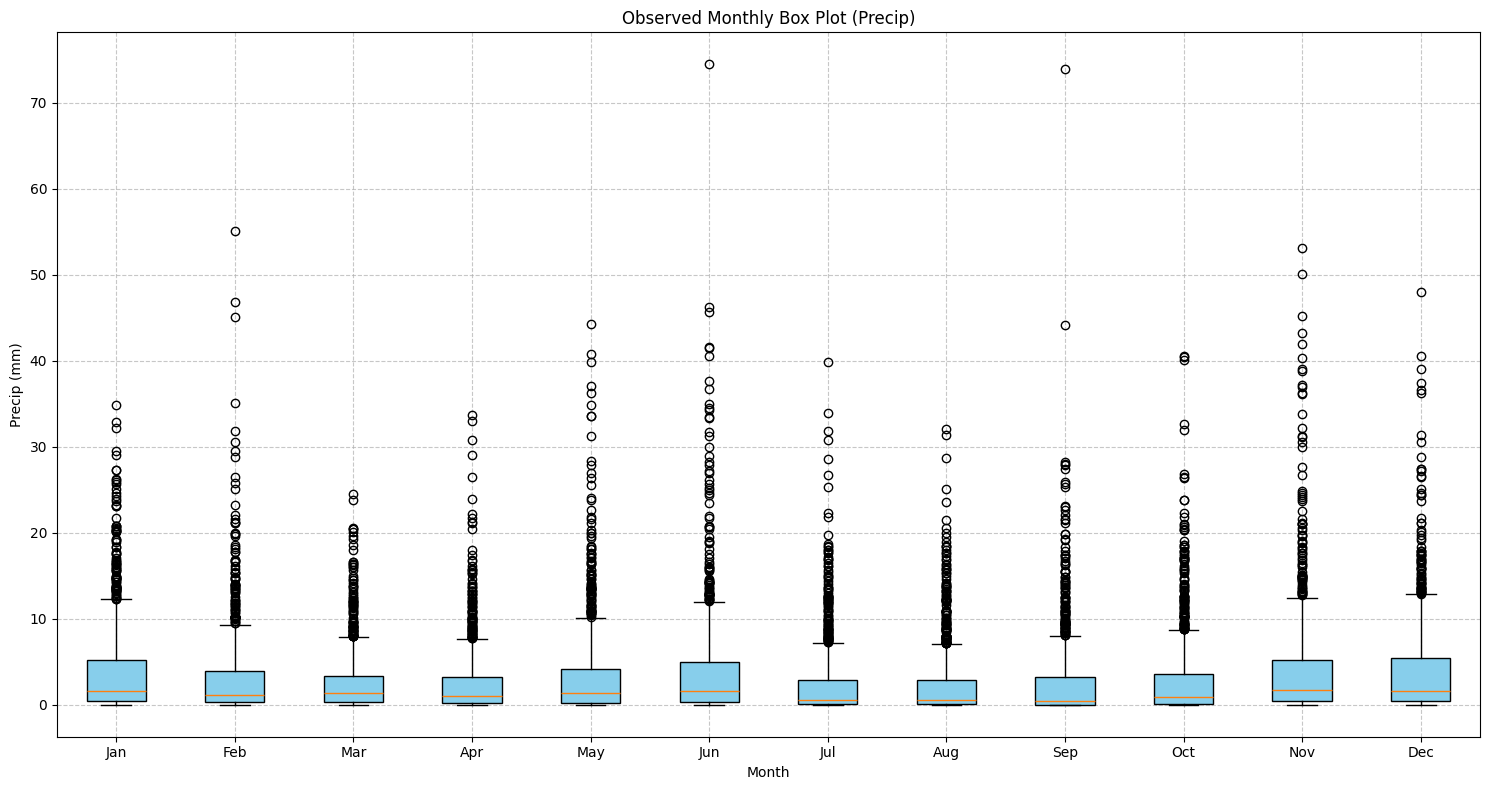

In [132]:
plot_monthly_boxplot(observed_dfs, 'precip', title_prefix='Observed')


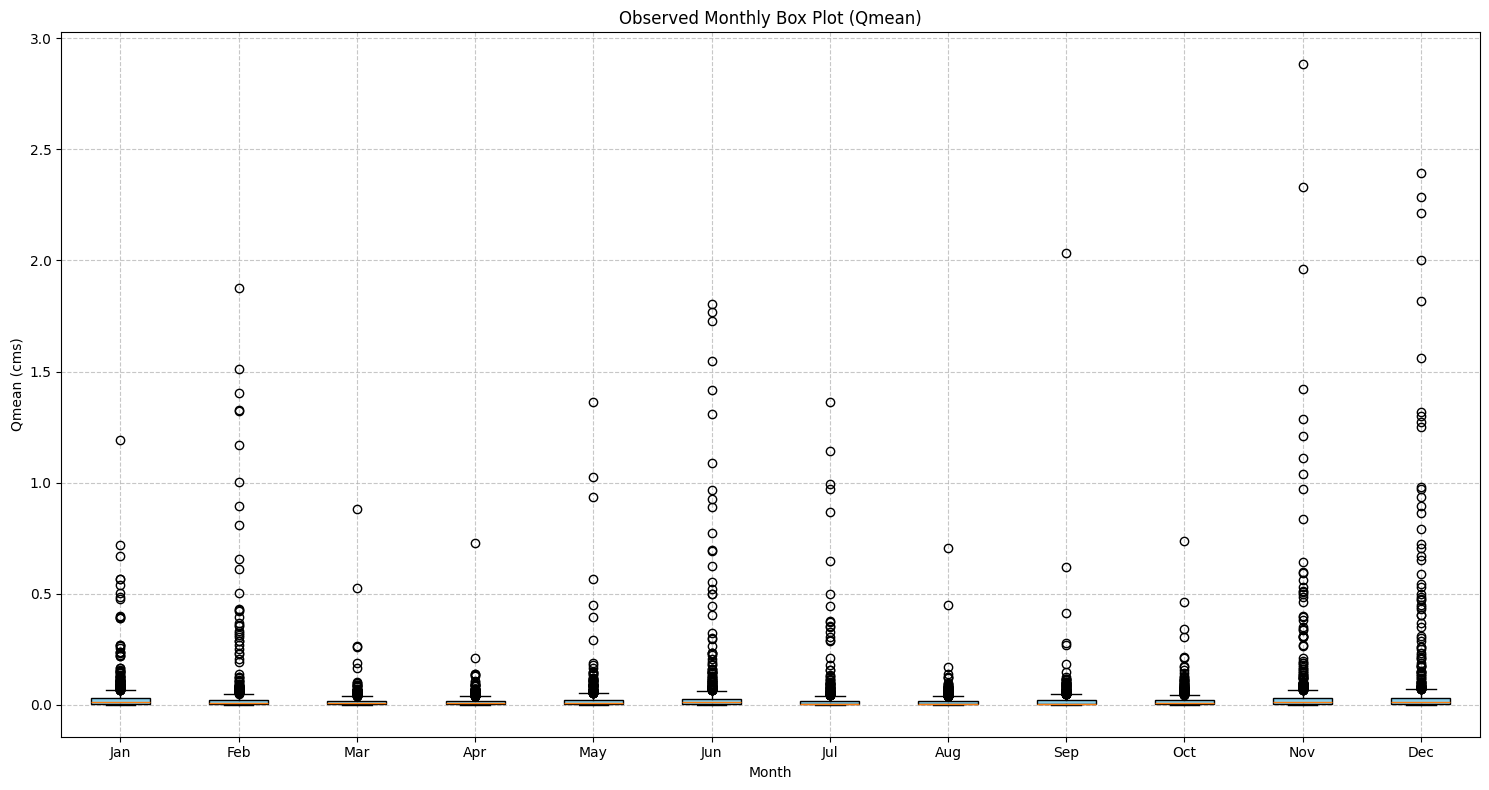

In [133]:
plot_monthly_boxplot(observed_dfs, 'qmean', title_prefix='Observed')


## **Scenario 1:** SSP1-2.6 = *assumes reduced emissions*

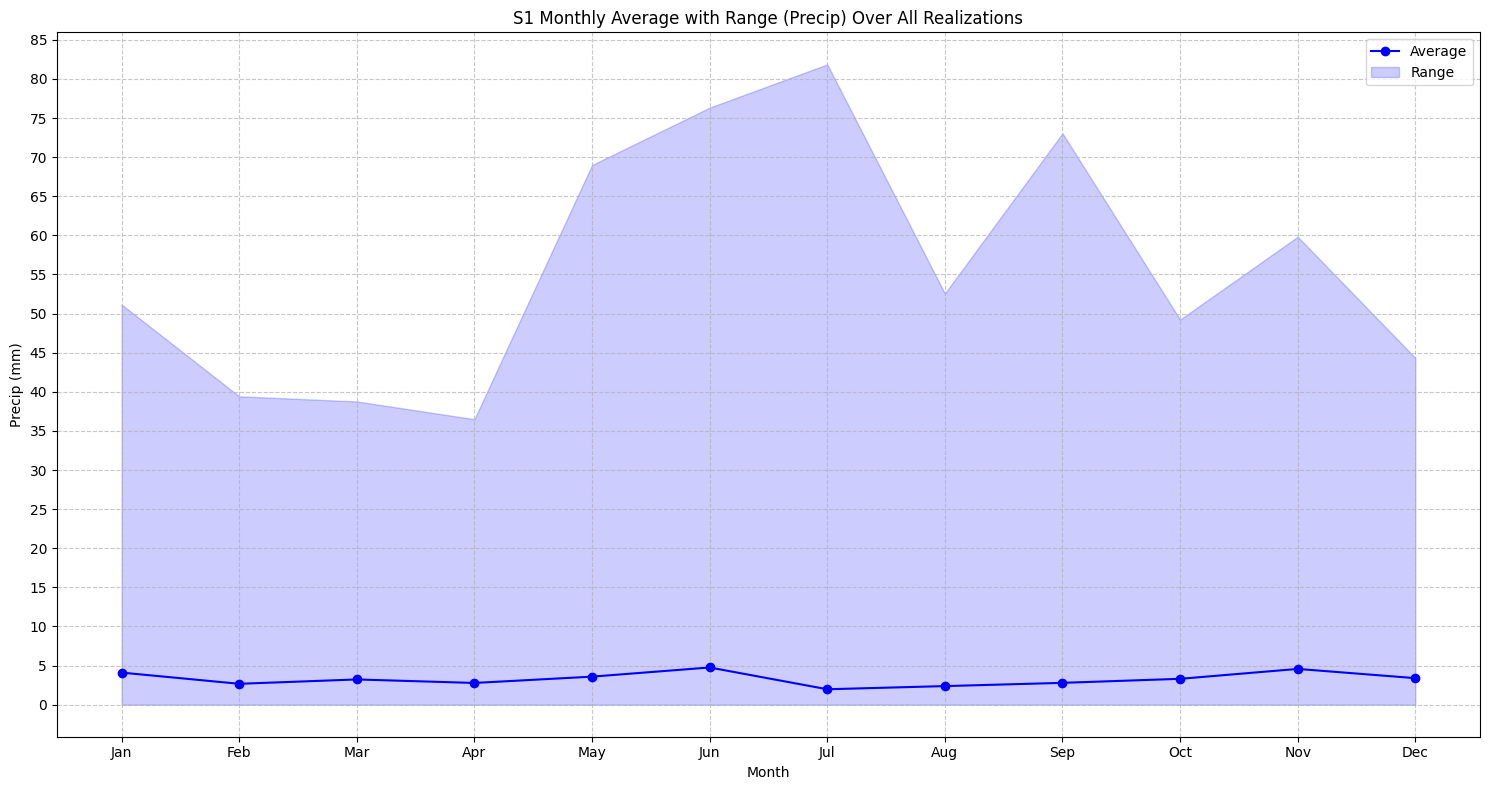

In [134]:
plot_monthly_average_with_range(s1_t_p, 'precip', title_prefix="S1") #just change the df going in

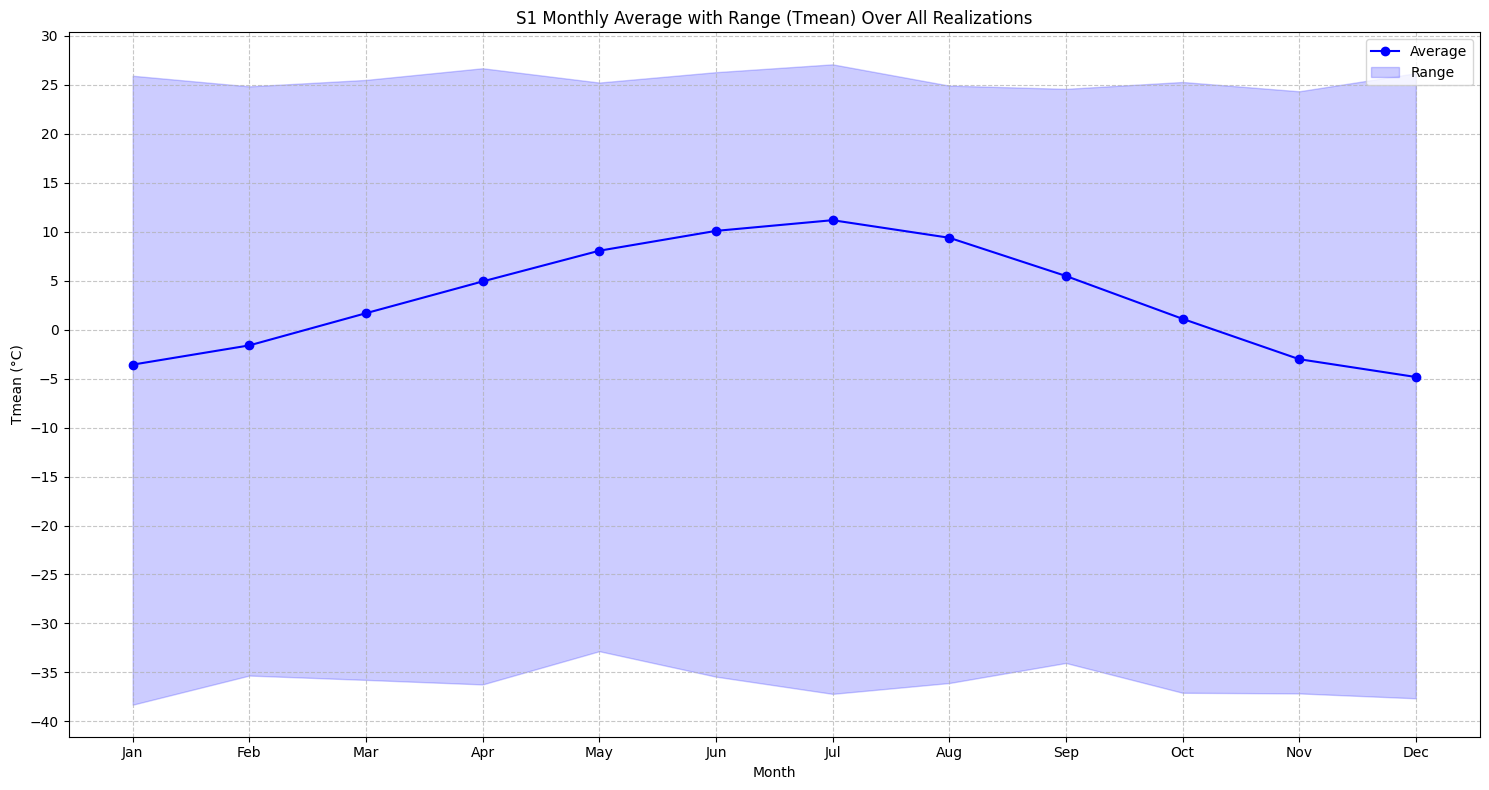

In [135]:
plot_monthly_average_with_range(s1_t_p, 'tmean', title_prefix="S1")

In [32]:
# TODO: do for flow!
# plot_monthly_average_with_range(s1_t_p, 'qmean', title_prefix="S1")

In [33]:
# plot_mean_monthly_trends(s1_t_p, 'tmean', title_prefix='S1') # change the dataframe list to s1_dfs when done

In [34]:
# plot_mean_monthly_trends(s1_t_p, 'precip', title_prefix='S1')

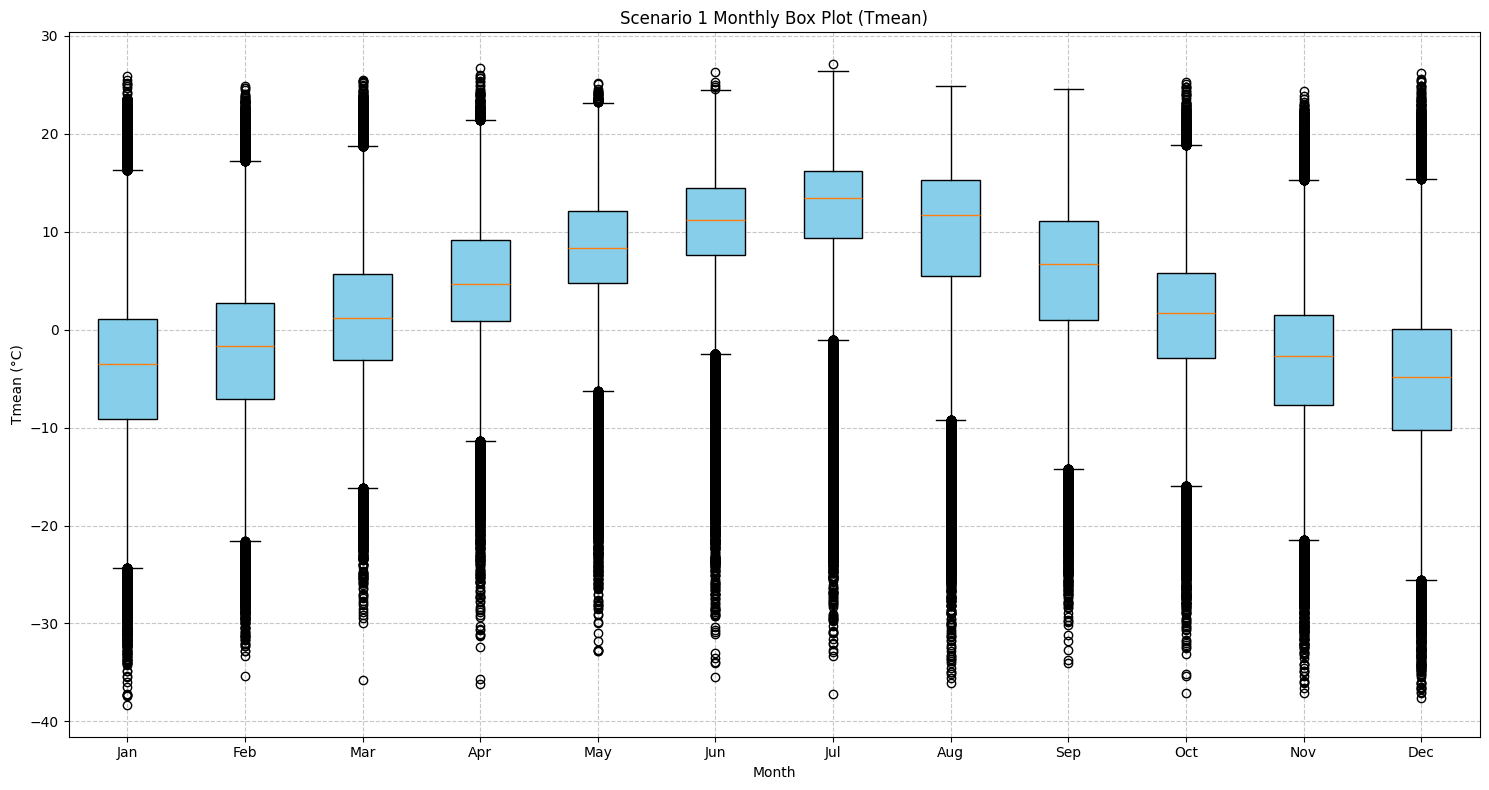

In [136]:
plot_monthly_boxplot(s1_t_p, 'tmean', title_prefix='Scenario 1')


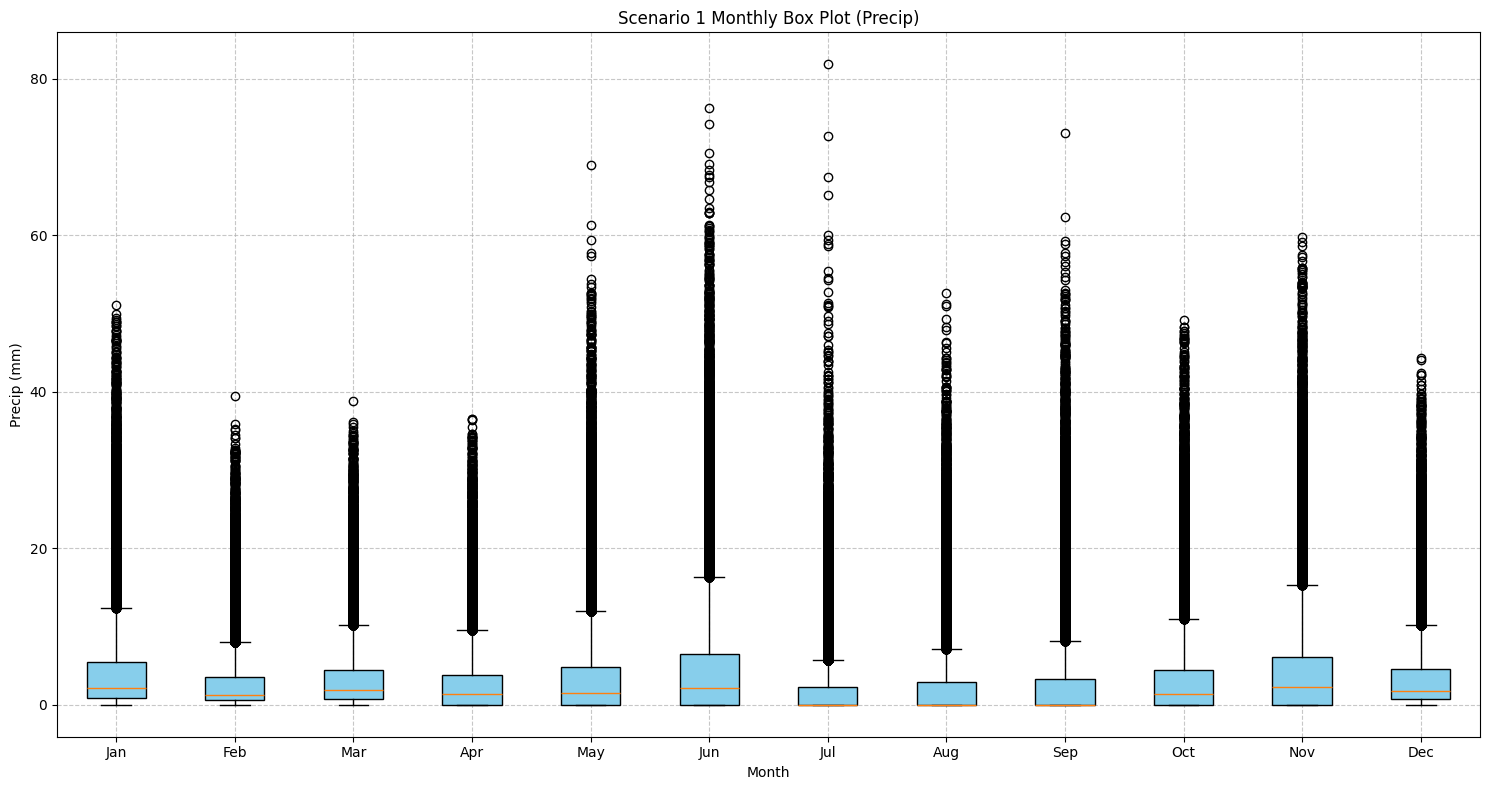

In [137]:
plot_monthly_boxplot(s1_t_p, 'precip', title_prefix='Scenario 1')


## **Scenario 2:** SSP2-4.5 = *assumes the same trend of emissions as historical*

## **Scenario 3:** SSP3-7.0 = *medium to high emissions scenario*

## **Scenario 4:** SSP5-8.5 = *optimal for economic development but with high emissions.*

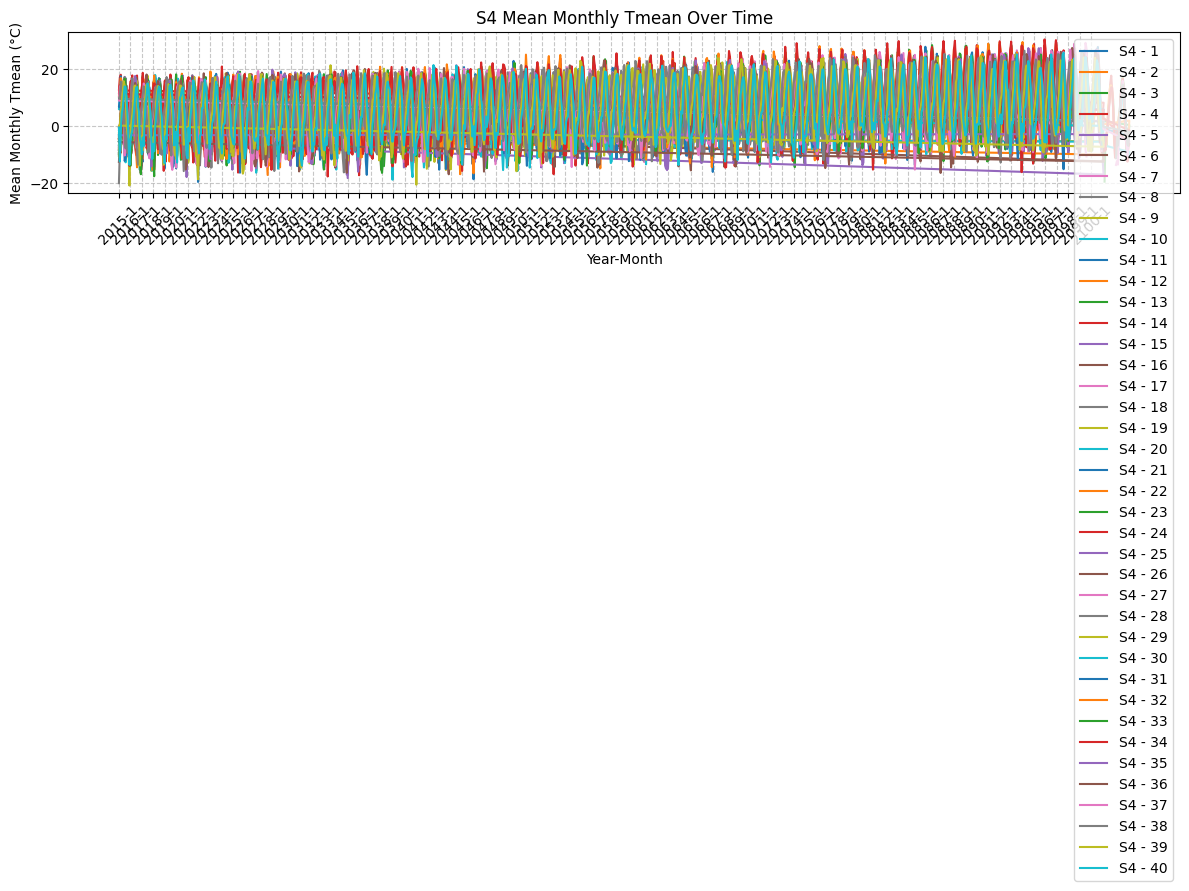

In [69]:
plot_mean_monthly_trends(s4_t_p, 'tmean', title_prefix='S4') # shows a steady upward trend of temperature where averages are around 15 deg c
# larger extremes

## Comparison

C:\Users\14037\AppData\Local\Temp\ipykernel_31668\1806209303.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black') for i in range(len(list_of_df_lists))]


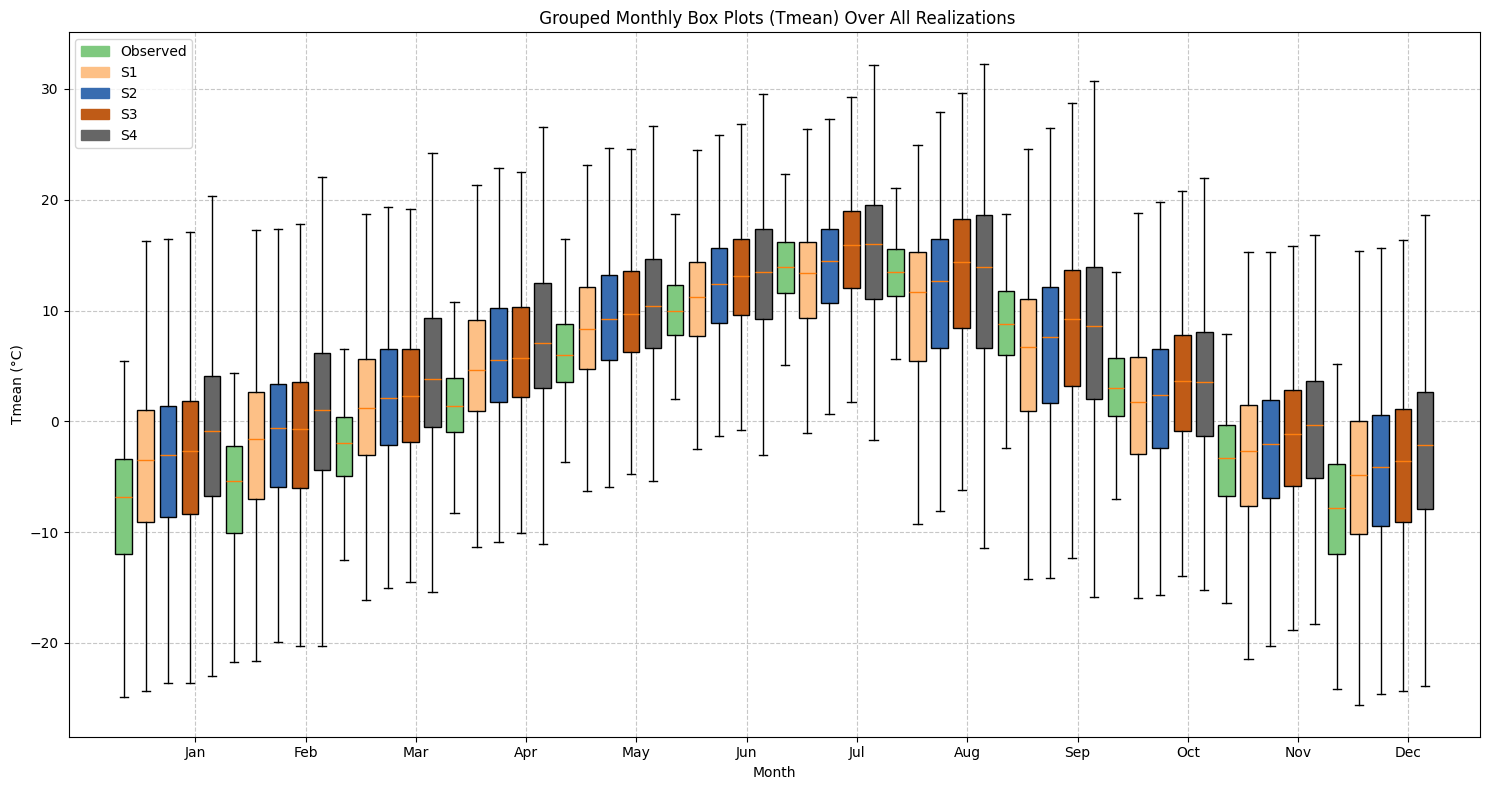

In [138]:
list_of_df_lists = [observed_dfs, s1_t_p, s2_t_p, s3_t_p, s4_t_p]
plot_monthly_grouped_boxplots(list_of_df_lists, 'tmean')